### Preparations

In [1]:
# Required Imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math

# Use CUDA GPU device if available, else use CPU
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

cuda


### Load and Preprocess Data

In [2]:
# Load and Test Cornell Movie Dialogue corpus
corpus = "cornell movie-dialogs corpus"

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

# Dataset 
printLines(os.path.join(corpus, "movie_lines.txt"))


b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"
b'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow\n'
b"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.\n"
b'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No\n'
b'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n'
b'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?\n'


### Create Formatted Data File

In [3]:
# Splits each line of the file into a dictionary of fields
def loadLines(fileName, fields):
    lines = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            lineObj = {}
            for i, field in enumerate(fields):
                lineObj[field] = values[i]
            lines[lineObj['lineID']] = lineObj
    return lines


# Groups fields of lines from `loadLines` into conversations based on *movie_conversations.txt*
def loadConversations(fileName, lines, fields):
    conversations = []
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            convObj = {}
            for i, field in enumerate(fields):
                convObj[field] = values[i]
            # Convert string to list (convObj["utteranceIDs"] == "['L598485', 'L598486', ...]")
            utterance_id_pattern = re.compile('L[0-9]+')
            lineIds = utterance_id_pattern.findall(convObj["utteranceIDs"])
            # Reassemble lines
            convObj["lines"] = []
            for lineId in lineIds:
                convObj["lines"].append(lines[lineId])
            conversations.append(convObj)
    return conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations:
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

In [4]:
# Dataset 1 - Define path to new file
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict, conversations list, and field ids
lines = {}
conversations = []
MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]
MOVIE_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"]

# Load lines and process conversations
print("\nProcessing corpus...")
lines = loadLines(os.path.join(corpus, "movie_lines.txt"), MOVIE_LINES_FIELDS)
print("\nLoading conversations...")
conversations = loadConversations(os.path.join(corpus, "movie_conversations.txt"),
                                  lines, MOVIE_CONVERSATIONS_FIELDS)

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# Print a sample of lines
print("\nSample lines from file:")
printLines(datafile)


Processing corpus...

Loading conversations...

Writing newly formatted file...

Sample lines from file:
b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\r\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\r\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\r\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\r\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\r\n"
b"Cameron.\tThe thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\r\n"
b"The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister. 

### Load and Trim Data

In [5]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [6]:
MAX_LENGTH = 10  # Maximum sentence length to consider 

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus, datafile, save_dir)   # SECOND CORPUS WAS corpus_name
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:1000]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64271 sentence pairs
Counting words...
Counted words: 18008

pairs:
['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']
['the real you .', 'like my fear of wearing pastels ?']
['wow', 'let s go .']
['she okay ?', 'i hope so .']
['they do to !', 'they do not !']
['did you change your hair ?', 'no .']
['no .', 'you might wanna think about it']
['who ?', 'joey .']
['great', 'would you mind getting me a drink cameron ?']
['it s more', 'expensive ?']
['hey sweet cheeks .', 'hi joey .']
['where ve you been 

In [7]:
MIN_COUNT = 3    # Minimum word count threshold for trimming 
print(device)
def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

cuda
keep_words 7823 / 18005 = 0.4345
Trimmed from 64271 pairs to 53165, 0.8272 of total


### Prepare Data for Models

In [8]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[   7,  167,   50,  464,   33],
        [ 359,   42,  102,    6,    6],
        [  18,    7,   36,    2,    2],
        [   7,    7,    6,    0,    0],
        [ 122,  534,    2,    0,    0],
        [  25,   12,    0,    0,    0],
        [   4,  780,    0,    0,    0],
        [   4, 1559,    0,    0,    0],
        [   4,    4,    0,    0,    0],
        [   2,    2,    0,    0,    0]])
lengths: tensor([10, 10,  5,  3,  3])
target_variable: tensor([[   7,   25,  124,   67,   25],
        [  92,    8,  303,   38, 1439],
        [1343,   12,    4,   36,   76],
        [4554, 3223,    2, 3592,  115],
        [   4, 1559,    0,    4,   67],
        [   2,    4,    0,    2,  349],
        [   0,    2,    0,    0, 1440],
        [   0,    0,    0,    0,    4],
        [   0,    0,    0,    0,    2]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  Tr

### Define Models

In [131]:
# Encoder RNN

class RNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                            dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):

        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths.cpu())
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)

        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]

        return outputs, hidden

# Encoder MLP 
class MLP(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(MLP, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        
        #As MLP is an RNN Model that has at least 3 Fully-Connected Layers
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                            dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        
        # Convert word indexes to embeddings
        output = self.embedding(input_seq)
       
        # 3 fully connected layer, the output of the first layer becomes the input of the second layer and same goes to layer 3
        output = self.fc1(output)
        output = F.relu(output)
        output = self.fc2(output)
        output = F.relu(output)
        output = self.fc3(output)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(output, input_lengths.cpu())

        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
          
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)

        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]

        # Return output and final hidden state
        return outputs, hidden        

# # Encoder Long-Short Term Memory (LSTM)
class LSTM(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        
        self.LSTM = nn.LSTM(hidden_size, hidden_size, n_layers,
                            dropout=(0 if n_layers == 1 else dropout))  

    def forward(self, input_seq, input_lengths, hidden=None):
        
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths.cpu())
        # Forward pass through GRU
        outputs, hidden = self.LSTM(packed, hidden)

        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)

        # Return output and final hidden state
        return outputs, hidden

In [100]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [101]:
class LuongAttnDecoder(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, model_type, n_layers=1, dropout=0.1):
        super(LuongAttnDecoder, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.model_type = model_type
        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        if self.model_type == "RNN" or self.model_type == "MLP":
            self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))  
        elif self.model_type == "LSTM":
            self.LSTM = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))    
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)

        # Forward through unidirectional GRU
        if self.model_type == "RNN" or self.model_type == "MLP":
            rnn_output, hidden = self.gru(embedded, last_hidden)
        elif self.model_type == "LSTM":
            rnn_output, hidden = self.LSTM(embedded, last_hidden)

        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden


### Define Training Procedure

In [103]:
# Masked Loss
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [104]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [105]:
import matplotlib.pyplot as plt

def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, 
               save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename, model_embedding):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    print_loss_avg_arr = []
    
    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            # Matplotlib Plot
            if model_embedding == 'RNN':
              writer.add_scalar('RNN Loss/train', print_loss_avg, iteration)
              print("Iteration: {}; Percent complete: {:.1f}%; Average RNN loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
              print_loss_avg_arr.append(print_loss_avg)
              print_loss = 0
            if model_embedding == 'LSTM':
              writer.add_scalar('LSTM Loss/train', print_loss_avg, iteration)
              print("Iteration: {}; Percent complete: {:.1f}%; Average LSTM loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
              print_loss_avg_arr.append(print_loss_avg)
              print_loss = 0
            if model_embedding == 'MLP':
              writer.add_scalar('MLP Loss/train', print_loss_avg, iteration)
              print("Iteration: {}; Percent complete: {:.1f}%; Average MLP loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
              print_loss_avg_arr.append(print_loss_avg)
              print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))
    return print_loss_avg_arr


### Greedy Decoding

In [106]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:self.decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

### Evaluate My Text

In [137]:
from collections import Counter
import nltk, math, re, numpy as np, nltk.translate.bleu_score as bleu_score

def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
   
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words

def Cos_Sim_Evaluate(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def evaluateInput(encoder, decoder, searcher, voc):
    WORD = re.compile(r"\w+")
    input_sentence = ''
    global results
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)

            # Evaluate using BLEU Score Algorithm
            scoring = {
                "reference_sentence": output_words[:],
                "test_sentence": input_sentence,
                "smoothing": bleu_score.SmoothingFunction().method4
            }
            BLEU_score = bleu_score.sentence_bleu(scoring["reference_sentence"], scoring["test_sentence"],smoothing_function=scoring["smoothing"])

            # Evaluate using Cosine Similarity Algorithm
            ref_sent_vector = Counter(WORD.findall(str(scoring["reference_sentence"])))
            test_sent_vector = Counter(WORD.findall(str(scoring["test_sentence"])))
            cosine = Cos_Sim_Evaluate(ref_sent_vector, test_sent_vector)

            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))
            
            Chatbot_results ='Cosine Similarity: {:0.4f}; BLEU Score: {:0.4f}'.format(cosine, BLEU_score)
            print(Chatbot_results)

        except KeyError:
            print("Error: Encountered unknown word.")


### Run Model

In [138]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'      
hidden_size = 500        
encoder_n_layers = 4     
decoder_n_layers = 4     
dropout = 0.1             
batch_size = 64          
output_dim = 4

out_channels = 1

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000

print('Building encoders and decoders ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
# Initialize encoder & decoder models
encoder_RNN = RNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder_RNN = LuongAttnDecoder(attn_model, embedding, hidden_size, voc.num_words, 'RNN', decoder_n_layers, dropout)

encoder_MLP = MLP(hidden_size, embedding, encoder_n_layers, dropout)
decoder_MLP = LuongAttnDecoder(attn_model, embedding, hidden_size, voc.num_words, "MLP", decoder_n_layers, dropout)

encoder_LSTM = LSTM(hidden_size, embedding, encoder_n_layers, dropout)
decoder_LSTM = LuongAttnDecoder(attn_model, embedding, hidden_size, voc.num_words, "LSTM", decoder_n_layers, dropout)
# Use appropriate device
encoder_RNN = encoder_RNN.to(device)
decoder_RNN = decoder_RNN.to(device)

encoder_LSTM = encoder_LSTM.to(device)
decoder_LSTM = decoder_LSTM.to(device)

encoder_MLP = encoder_MLP.to(device)
decoder_MLP = decoder_MLP.to(device)

print('Models built and ready to go!')


Building encoders and decoders ...
Models built and ready to go!


### Run Training

In [139]:
# Configure training/optimization
import pandas as pd, time

clip = 5.0                       
teacher_forcing_ratio = 1.0       
learning_rate = 0.0001            
decoder_learning_ratio = 5.0      
n_iteration = 8000                
print_every = 1
save_every = 500                 

# Ensure dropout layers are in train mode
encoder_RNN.train()
decoder_RNN.train()

encoder_LSTM.train()
decoder_LSTM.train()

encoder_MLP.train()
decoder_MLP.train()


# Initialize optimizers
print('Building optimizers ...')
encoder_RNN_optimizer = optim.Adam(encoder_RNN.parameters(), lr=learning_rate)
decoder_RNN_optimizer = optim.Adam(decoder_RNN.parameters(), lr=learning_rate * decoder_learning_ratio)

encoder_MLP_optimizer = optim.Adam(encoder_MLP.parameters(), lr=learning_rate)
decoder_MLP_optimizer = optim.Adam(decoder_MLP.parameters(), lr=learning_rate * decoder_learning_ratio)

encoder_LSTM_optimizer = optim.Adam(encoder_LSTM.parameters(), lr=learning_rate)
decoder_LSTM_optimizer = optim.Adam(decoder_LSTM.parameters(), lr=learning_rate * decoder_learning_ratio)


for state in encoder_RNN_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in encoder_LSTM_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in encoder_MLP_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()


for state in decoder_RNN_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_LSTM_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_MLP_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# Run training iterations

RNN_start_time = time.time()

print("Starting Training RNN!")
losses = trainIters(model_name, voc, pairs, encoder_RNN, decoder_RNN, encoder_RNN_optimizer, decoder_RNN_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus, loadFilename, "RNN")
print("RNN Training complete!")

RNN_end_time = time.time()
print("Time spent to execute RNN: ", RNN_end_time - RNN_start_time)

dict1 = {"Losses": losses, "Iterations": list(range(1, n_iteration+1))}
df1 = pd.DataFrame(dict1)
df1.to_csv('RNN_Training_results/loss_vs_iters6.csv', sep=',', index=False, encoding='utf-8') 

MLP_start_time = time.time()

print("Starting Training MLP!")
losses = trainIters(model_name, voc, pairs, encoder_MLP, decoder_MLP, encoder_MLP_optimizer, decoder_MLP_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus, loadFilename, 'MLP')
print("MLP Training complete!")

MLP_end_time = time.time()
print("Time spent to execute MLP: ", MLP_end_time - MLP_start_time)

dict1 = {"Losses": losses, "Iterations": list(range(1, n_iteration+1))}
df1 = pd.DataFrame(dict1)
df1.to_csv('MLP_Training_results/loss_vs_iters6.csv', sep=',', index=False, encoding='utf-8') 

LSTM_start_time = time.time()

print("Starting Training LSTM!")
losses = trainIters(model_name, voc, pairs, encoder_LSTM, decoder_LSTM, encoder_LSTM_optimizer, decoder_LSTM_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus, loadFilename, 'LSTM')
print("LSTM Training complete!")

LSTM_end_time = time.time()
print("Time spent to execute LSTM: ", LSTM_end_time - LSTM_start_time)


dict1 = {"Losses": losses, "Iterations": list(range(1, n_iteration+1))}
df1 = pd.DataFrame(dict1)
df1.to_csv('LSTM_Training_results/loss_vs_iters6.csv', sep=',', index=False, encoding='utf-8') 



Building optimizers ...
Starting Training RNN!
Initializing ...
Training...
Iteration: 1; Percent complete: 0.0%; Average RNN loss: 8.9724
Iteration: 2; Percent complete: 0.0%; Average RNN loss: 8.8906
Iteration: 3; Percent complete: 0.0%; Average RNN loss: 8.7101
Iteration: 4; Percent complete: 0.1%; Average RNN loss: 8.2851
Iteration: 5; Percent complete: 0.1%; Average RNN loss: 7.7446
Iteration: 6; Percent complete: 0.1%; Average RNN loss: 7.2108
Iteration: 7; Percent complete: 0.1%; Average RNN loss: 6.9581
Iteration: 8; Percent complete: 0.1%; Average RNN loss: 6.9566
Iteration: 9; Percent complete: 0.1%; Average RNN loss: 6.9071
Iteration: 10; Percent complete: 0.1%; Average RNN loss: 6.7154
Iteration: 11; Percent complete: 0.1%; Average RNN loss: 6.1506
Iteration: 12; Percent complete: 0.1%; Average RNN loss: 6.1116
Iteration: 13; Percent complete: 0.2%; Average RNN loss: 6.0322
Iteration: 14; Percent complete: 0.2%; Average RNN loss: 5.8759
Iteration: 15; Percent complete: 0.2%

### Run Evaluation

In [140]:
# Set dropout layers to eval mode
encoder_RNN.eval()
decoder_RNN.eval()

encoder_LSTM.eval()
decoder_LSTM.eval()

encoder_MLP.eval()
decoder_MLP.eval()

# Initialize search module
RNN_Greedy = GreedySearchDecoder(encoder_RNN, decoder_RNN)

MLP_Greedy = GreedySearchDecoder(encoder_MLP, decoder_MLP)

LSTM_Greedy = GreedySearchDecoder(encoder_LSTM, decoder_LSTM)


# Begin chatting (uncomment and run the following line to begin)
print("Starting conversation with RNN!")
evaluateInput(encoder_RNN, decoder_RNN, RNN_Greedy, voc)

print("Starting conversation with MLP!")
evaluateInput(encoder_MLP, decoder_MLP, MLP_Greedy, voc)

print("Starting conversation with LSTM!")
evaluateInput(encoder_LSTM, decoder_LSTM, LSTM_Greedy, voc)



Starting conversation with RNN!
Bot: hi . me to meet you .
Cosine Similarity: 0.2673; BLEU Score: 0.2214
Bot: hello . me jake . singer .
Cosine Similarity: 0.2774; BLEU Score: 1.0000
Bot: i m fine . yourself . !
Cosine Similarity: 0.0000; BLEU Score: 0.1106
Bot: no . you look later . !
Cosine Similarity: 0.1240; BLEU Score: 0.0903
Bot: i m sorry . out of your life
Cosine Similarity: 0.0000; BLEU Score: 0.0000
Bot: i m martha mama . up .
Cosine Similarity: 0.0000; BLEU Score: 0.0526
Starting conversation with MLP!
Bot: you re late . examiner .
Cosine Similarity: 0.0000; BLEU Score: 0.0600
Bot: you re late . examiner .
Cosine Similarity: 0.0000; BLEU Score: 0.0600
Bot: good morning swana . a minute .
Cosine Similarity: 0.1890; BLEU Score: 0.4240
Bot: hello . my feet and grab up .
Cosine Similarity: 0.0000; BLEU Score: 0.0000
Bot: you re opal . me here .
Cosine Similarity: 0.0000; BLEU Score: 0.1441
Bot: you know . the other one .
Cosine Similarity: 0.0000; BLEU Score: 0.0309
Bot: i m fin

### Training attempts with their associated hyperparamters, and last recorded avg loss fo RNN, MLP and LSTM models 

In [90]:
from IPython.display import display, HTML

df = pd.read_csv('Training_Stats.csv')
display(HTML(df.to_html()))

,Training,Number of Iterations,Decoder Learning Ratio,Encoder and Decoder Layers,Attention Method,Learning Rate,Batch Size,Hidden Size,RNN Training Time (in Minutes),MLP Training Time (in Minutes),LSTM Training Time (in Minutes),RNN Last Reached Average Loss,MLP Last Reached Average Loss,LSTM Last Reached Average Loss
0,1,4000,5,2,Dot,0.0001,64,500,2.54,3.0,3.26,2.7496,2.7532,2.9645
1,2,6000,5,2,Dot,0.0001,64,500,4.45,4.0,4.00,2.1248,2.2984,1.7724
2,3,8000,5,2,Dot,0.0001,64,500,5.45,6.0,6.00,0.7991,1.4060,0.6535
3,4,8000,5,4,Dot,0.0001,64,500,8.30,9.3,7.20,1.8741,2.4837,2.6447
4,5,8000,5,4,Dot,0.0001,64,500,9.00,10.3,7.80,2.1900,2.6396,2.6109
5,6,8000,10,4,Dot,0.0001,64,500,10.00,7.3,7.71,1.8401,2.5934,2.4358


### Loss VS Iterations Graphs for RNN

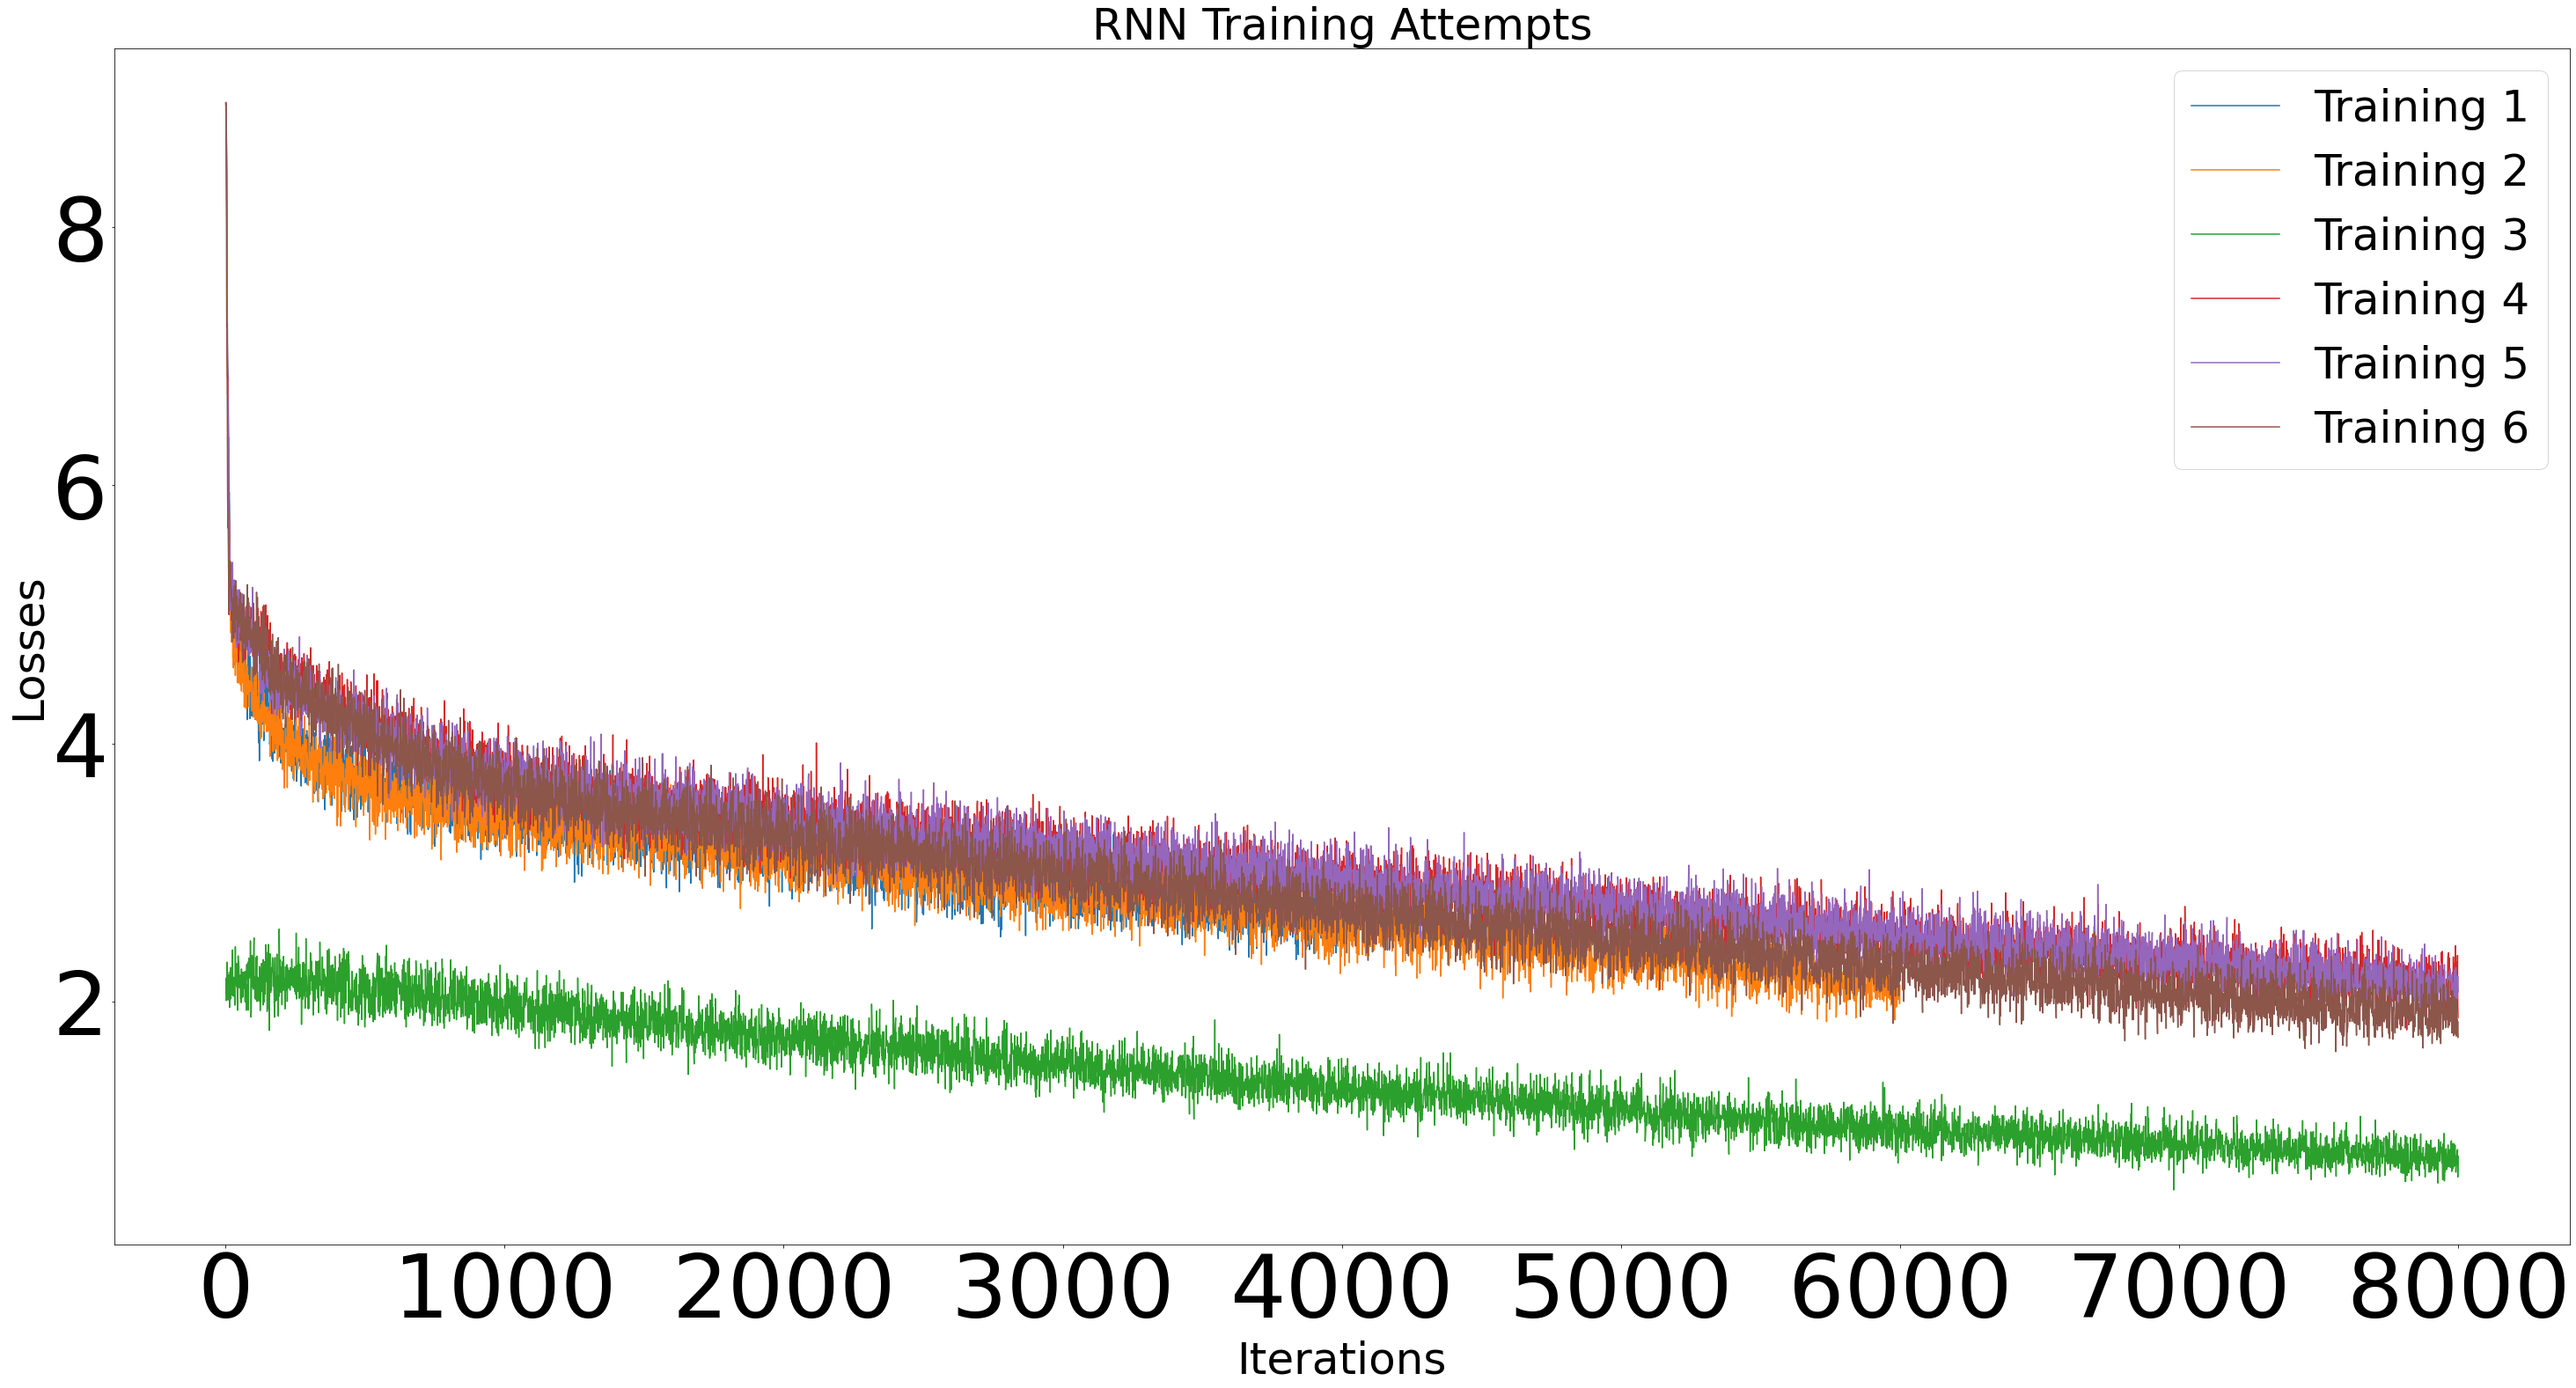

In [92]:
from IPython.display import display, HTML

rnn_training1 = pd.read_csv('RNN_Training_results/loss_vs_iters1.csv')
rnn_training2 = pd.read_csv('RNN_Training_results/loss_vs_iters2.csv')
rnn_training3 = pd.read_csv('RNN_Training_results/loss_vs_iters3.csv')
rnn_training4 = pd.read_csv('RNN_Training_results/loss_vs_iters4.csv')
rnn_training5 = pd.read_csv('RNN_Training_results/loss_vs_iters5.csv')
rnn_training6 = pd.read_csv('RNN_Training_results/loss_vs_iters6.csv')

fontsize = 50
plt.xlabel("Iterations", fontsize=fontsize)
plt.ylabel("Losses", fontsize=fontsize)
plt.title("RNN Training Attempts", fontsize=fontsize)
plt.plot(rnn_training1["Iterations"], rnn_training1["Losses"])
plt.plot(rnn_training2["Iterations"], rnn_training2["Losses"])
plt.plot(rnn_training3["Iterations"], rnn_training3["Losses"])
plt.plot(rnn_training4["Iterations"], rnn_training4["Losses"])
plt.plot(rnn_training5["Iterations"], rnn_training5["Losses"])
plt.plot(rnn_training6["Iterations"], rnn_training6["Losses"])
plt.legend(["Training 1", "Training 2", "Training 3", "Training 4", "Training 5", "Training 6"], loc ="upper right", fontsize=fontsize)
plt.show()



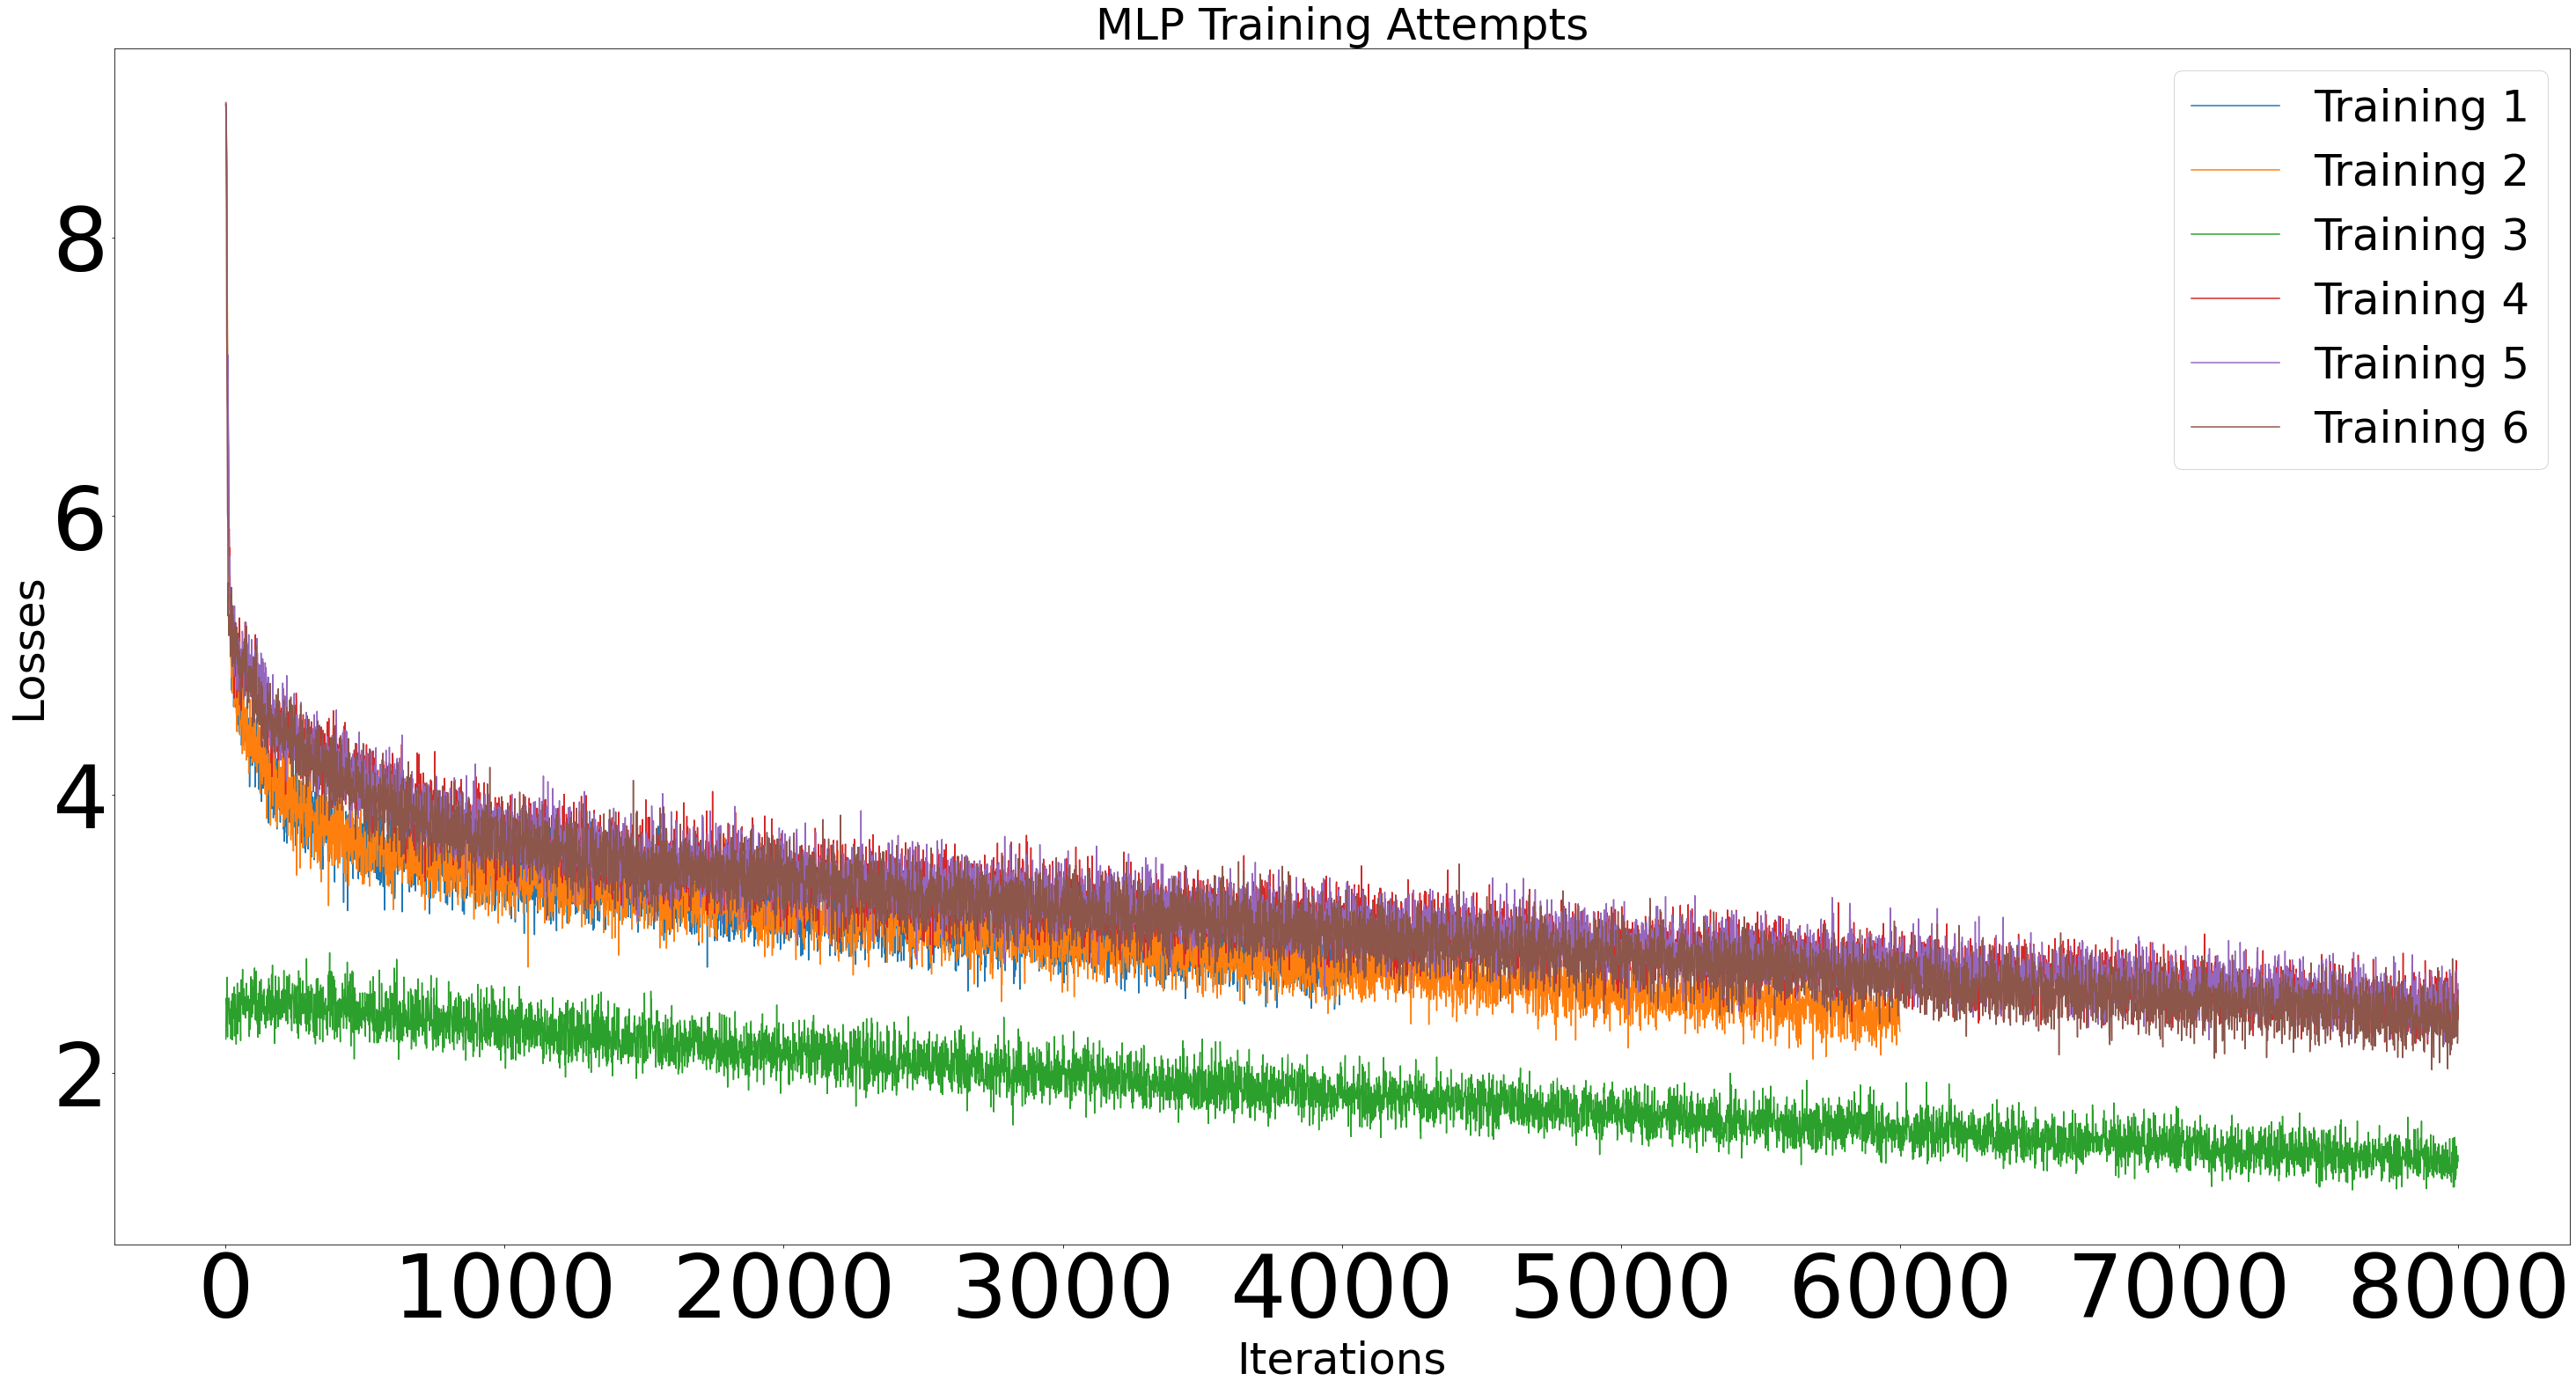

In [94]:
from IPython.display import display, HTML

MLP_training1 = pd.read_csv('MLP_Training_results/loss_vs_iters1.csv')
MLP_training2 = pd.read_csv('MLP_Training_results/loss_vs_iters2.csv')
MLP_training3 = pd.read_csv('MLP_Training_results/loss_vs_iters3.csv')
MLP_training4 = pd.read_csv('MLP_Training_results/loss_vs_iters4.csv')
MLP_training5 = pd.read_csv('MLP_Training_results/loss_vs_iters5.csv')
MLP_training6 = pd.read_csv('MLP_Training_results/loss_vs_iters6.csv')

fontsize = 50
plt.xlabel("Iterations", fontsize=fontsize)
plt.ylabel("Losses", fontsize=fontsize)
plt.title("MLP Training Attempts", fontsize=fontsize)
plt.plot(MLP_training1["Iterations"], MLP_training1["Losses"])
plt.plot(MLP_training2["Iterations"], MLP_training2["Losses"])
plt.plot(MLP_training3["Iterations"], MLP_training3["Losses"])
plt.plot(MLP_training4["Iterations"], MLP_training4["Losses"])
plt.plot(MLP_training5["Iterations"], MLP_training5["Losses"])
plt.plot(MLP_training6["Iterations"], MLP_training6["Losses"])
plt.legend(["Training 1", "Training 2", "Training 3", "Training 4", "Training 5", "Training 6"], loc ="upper right", fontsize=fontsize)
plt.show()



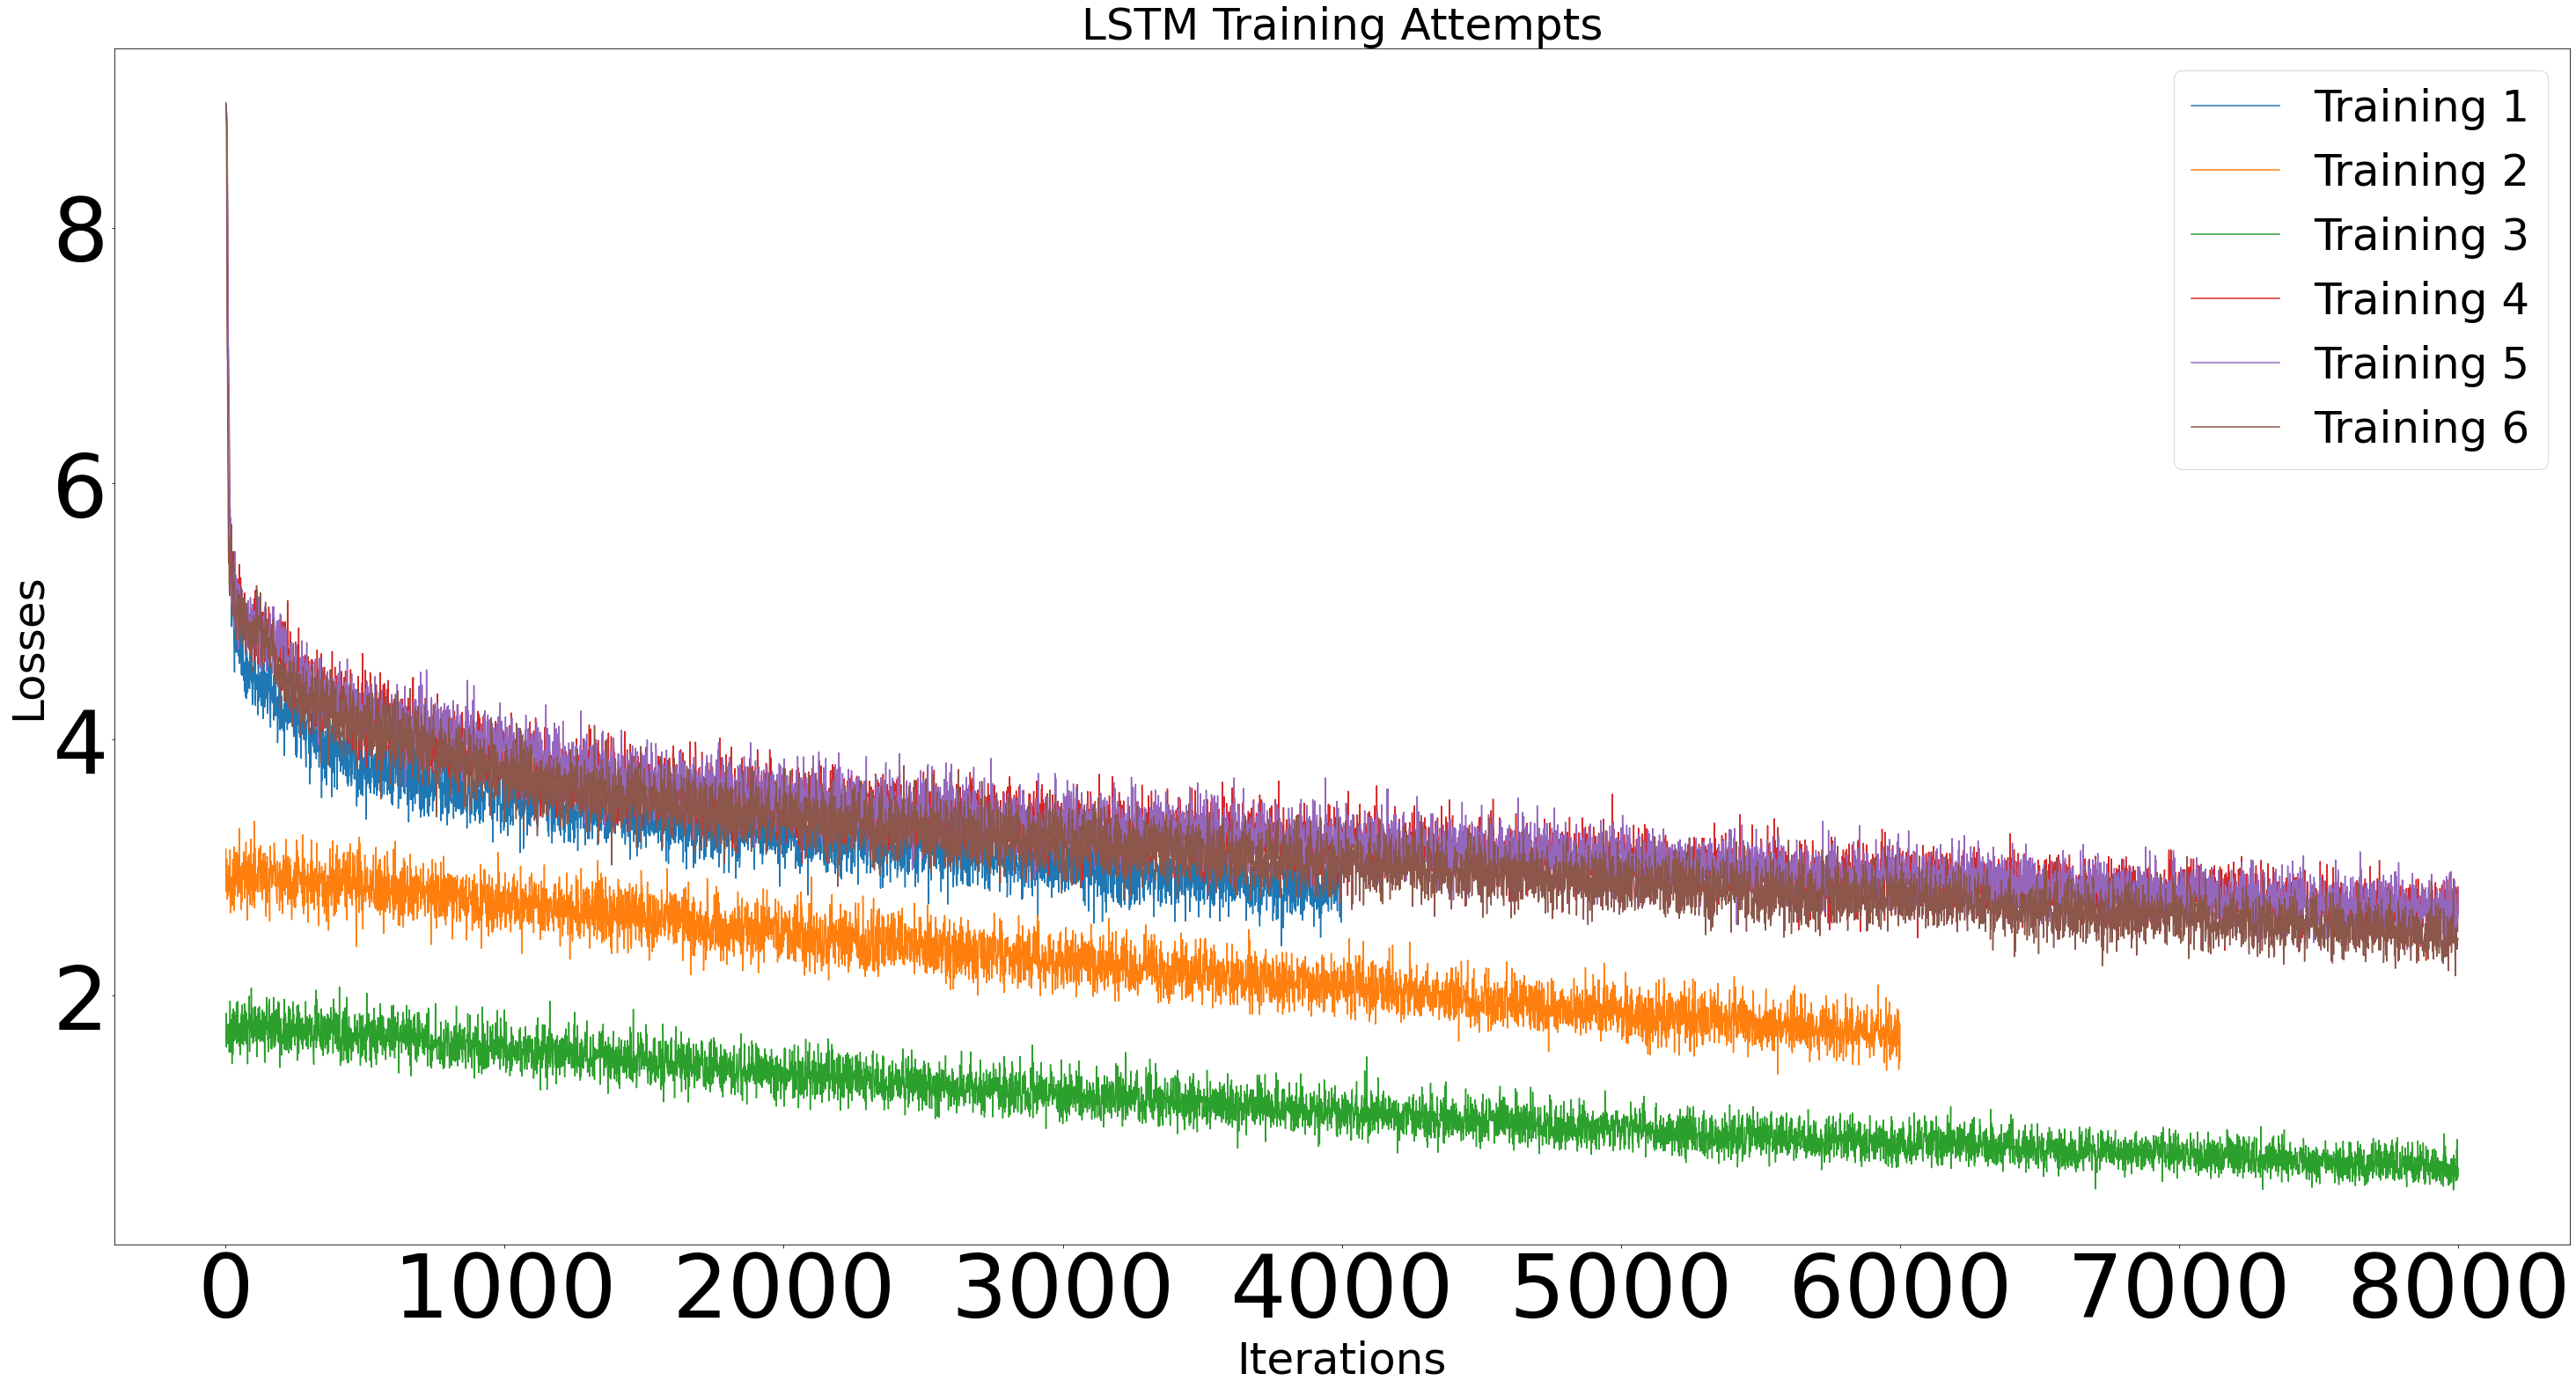

In [95]:
from IPython.display import display, HTML

LSTM_training1 = pd.read_csv('LSTM_Training_results/loss_vs_iters1.csv')
LSTM_training2 = pd.read_csv('LSTM_Training_results/loss_vs_iters2.csv')
LSTM_training3 = pd.read_csv('LSTM_Training_results/loss_vs_iters3.csv')
LSTM_training4 = pd.read_csv('LSTM_Training_results/loss_vs_iters4.csv')
LSTM_training5 = pd.read_csv('LSTM_Training_results/loss_vs_iters5.csv')
LSTM_training6 = pd.read_csv('LSTM_Training_results/loss_vs_iters6.csv')

fontsize = 50
plt.xlabel("Iterations", fontsize=fontsize)
plt.ylabel("Losses", fontsize=fontsize)
plt.title("LSTM Training Attempts", fontsize=fontsize)
plt.plot(LSTM_training1["Iterations"], LSTM_training1["Losses"])
plt.plot(LSTM_training2["Iterations"], LSTM_training2["Losses"])
plt.plot(LSTM_training3["Iterations"], LSTM_training3["Losses"])
plt.plot(LSTM_training4["Iterations"], LSTM_training4["Losses"])
plt.plot(LSTM_training5["Iterations"], LSTM_training5["Losses"])
plt.plot(LSTM_training6["Iterations"], LSTM_training6["Losses"])
plt.legend(["Training 1", "Training 2", "Training 3", "Training 4", "Training 5", "Training 6"], loc ="upper right", fontsize=fontsize)
plt.show()



### Chatbot Conversations comparison between the three models along with scoring using Cosing Similarity and BLEU Score mechanisms 

In [97]:
from IPython.display import display, HTML

df = pd.read_csv('Training_Scoring_Using_BLEU_and_Cosine_Similarity.csv')
display(HTML(df.to_html()))

,Training Trial,Choice of Dialog,User Input,Chatbot Output (RNN),Cosine Score (RNN),BLEU Score (RNN),Chatbot Output (MLP),Cosine Score (MLP),BLEU Score (MLP),Chatbot Output (LSTM),Cosine Score (LSTM),BLEU Score (LSTM)
0,1,Greetings,hi,hi . ? ? ? ?,0.2425,0.2214,hi . . . . .,0.2425,0.2214,hi . . . .,0.2425,0.2214
1,1,Greetings,hello,hello . s coming up here . ?,0.3333,1.0000,hi . . . . .,0.0000,0.0456,hello . . . .,0.0000,0.0000
2,1,Greetings,good morning,good morning . ? ? ?,0.3333,0.6989,good morning . . . .,0.3333,0.6989,good morning . . .,0.2425,1.0000
3,1,Greetings,goodbye,goodbye . ? ? ? ?,0.2425,1.0000,you re welcome . . . .,0.0000,0.0426,you re not sayin that ? ?,0.1667,0.2521
4,1,Queries,Who are you?,i m just looking for her . .,0.1601,0.0264,i m not . . .,0.0000,0.0187,i m here . of them .,0.0000,0.0238
5,1,Queries,Where am I?,i don t know . ? ?,0.0000,0.0000,you re in the bathroom . . .,0.0000,0.0747,i m not leaving . .,0.1601,0.0534
6,1,Queries,Where are you from?,i m in the bathroom . . ?,0.0000,0.0509,i m going to win . . .,0.0000,0.0172,southern california . of them . .,0.0000,0.0187
7,1,Queries,How are you?,i m fine . are you ? ?,0.3849,0.1701,i m fine . . . .,0.0000,0.0187,i m fine . . .,0.0000,0.0187
8,1,Queries,Are you my friend?,yes . ? ? ? ?,0.0179,0.0179,no . . . . .,0.0000,0.0162,no . . . .,0.0000,0.0391
9,2,Greetings,hi,hi . . . . . .,0.3162,0.2214,hi . ? ? ? ?,0.2425,0.2214,hi . ? ? ? ?,0.2425,0.2214


### Simple Rules-Based Chatbot using predefined Rules and conversations saved in a string using Regular Expressions

In [127]:
import re

rules = {'I want (.*)': ['What would it mean if you got {0}',
  'Why do you want {0}',
  "What's stopping you from getting {0}"],
 'do you remember (.*)': ['Did you think I would forget {0}',
  "Why haven't you been able to forget {0}",
  'What about {0}',
  'Yes .. and?'],
 'do you think (.*)': ['if {0}? Absolutely.', 'No chance'],
 'if (.*)': ["Do you really think it's likely that {0}",
  'Do you wish that {0}',
  'What do you think about {0}',
  'Really--if {0}']}


# Define match_rule()
def match_rule(rules, message):
    response, phrase = "Bye", None
    
    # Iterate over the rules dictionary
    for pattern, responses in rules.items():
        # Create a match object
        match = re.search(pattern,message)
        if match is not None:
            # Choose a random response
            response = random.choice(responses)
            if '{0}' in response:
                phrase = match.group(1)
    # Return the response and phrase
    return response, phrase

def replace_pronouns(message):

    message = message.lower()
    if 'me' in message:
        # Replace 'me' with 'you'
        return re.sub('me', 'you', message)
    if 'my' in message:
        # Replace 'my' with 'your'
        return re.sub('my', 'your', message)
    if 'your' in message:
        # Replace 'your' with 'my'
        return re.sub('your', 'my', message)
    if 'you' in message:
        # Replace 'you' with 'me'
        return re.sub('you', 'me', message)

    return message

def send_and_respond(message):
    response, phrase = match_rule(rules, message)
    if '{0}' in response:
        # Replace the pronouns in the phrase
        phrase = replace_pronouns(phrase)
        # Include the phrase in the response
        response = response.format(phrase)
    # Print user_template including the user_message
    print("Human: {0}".format(message))
    # Print the bot template including the bot's response.
    print("AI: {0}".format(response))

# Send the messages
send_and_respond("Do you remember when we met for the first time")
send_and_respond("I want a cup of coffee")
send_and_respond("what if you could be anything you wanted")
send_and_respond("Do you think humans should be worried about AI")


Human: Do you remember when we met for the first time
AI: Bye
Human: I want a cup of coffee
AI: What would it mean if you got a cup of coffee
Human: what if you could be anything you wanted
AI: What do you think about me could be anything me wanted
Human: Do you think humans should be worried about AI
AI: Bye
